In [1]:
import sys
sys.path.append("../Modules/")
sys.path.append("../")
import os

import pandas as pd
import numpy as np

from configobj import ConfigObj
from configobj import flatten_errors
from validate import Validator
    
import logging

from analysisParameters import loadParameters
from loadDataE1 import loadSessionDict
import processDataE1 as pF

#fmt = 'logging.Formatter(''%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)



In [2]:
#fileTime = '2018-4-27-13-41'
# fileTime = '2018-4-30-13-49'
fileTime = '2018-4-26-11-31'
analysisParameters = loadParameters(fileTime)
sessionDict = loadSessionDict(analysisParameters,
                              loadParsedData = False,
                              loadProcessedData = True)


INFO_loadDataE1-loadSessionDict(): - Loading preprocessed data for exp_data-2018-4-26-11-31 ***


In [3]:
# sessionDict = projectTrajectories(sessionDict)
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
subNum = 2
bNum = 2
tNum = 127


# subNum = 2
# bNum = 2
# tNum = 141


In [5]:
fileTimeList = [];
[fileTimeList.append(name) for name in os.listdir("../Data/") if name[0] is not '.'];
fileTimeList

from analysisParameters import loadParameters
from loadDataE1 import loadSessionDict
from processDataE1 import projectTrajectories

fileName = fileTimeList[subNum]
analysisParameters = loadParameters(fileName)

# set loadProcessedData to True if you want to reprocess the file.  
sessionDict = loadSessionDict(analysisParameters,
                                  loadParsedData = True,
                                  loadProcessedData = True)

sessionDict['processed']['subjectNumber'] = subNum
sessionDict['processed']['fileName'] = fileName




INFO_loadDataE1-loadSessionDict(): - Loading preprocessed data for exp_data-2018-4-27-12-32 ***


In [6]:
from processDataE1 import gazeAnalysisWindow
sessionDict = gazeAnalysisWindow(sessionDict, analyzeUntilXSToArrival =  .3, 
                                 stopAtXSToArrival = 0.1)
# sessionDict = gazeAnalysisWindow(sessionDict, analyzeUntilXSToArrival =  .2, 
#                                  stopAtXSToArrival = 0.075):

INFO_processDataE1-gazeAnalysisWindow(): - Added sessionDict['trialInfo']['analysisStartFr']
INFO_processDataE1-gazeAnalysisWindow(): - Added sessionDict['trialInfo']['analysisEndFr']


In [7]:
tr = sessionDict['processed'].groupby(('blockNumber','trialNumber')).get_group((bNum,tNum))
trInfo = sessionDict['trialInfo'].groupby(('blockNumber','trialNumber')).get_group((bNum,tNum))

### Parameters

In [8]:
winSize = 7
polyorder = 3
interpResMs = 1. / 1000

### Vector movement model

In [9]:
from scipy.signal import savgol_filter
sampleTime = sessionDict['raw']['frameTime'].diff().mode()
if len(sampleTime) > 1: sampleTime=sampleTime[0]
    
# trInfo = sessionDict['trialInfo'].groupby(('blockNumber','trialNumber')).get_group((bNum,tNum))

# Calculate velocity
cycToBallVel_az = savgol_filter(tr['ball_az'], winSize, polyorder, deriv=1, 
                                      delta= sampleTime, axis=0, mode='constant', cval=1.0)

cycToBallVel_el = savgol_filter(tr['ball_el'], winSize, polyorder, deriv=1, 
                                      delta= sampleTime, axis=0, mode='constant', cval=1.0)

startIdx = int(trInfo['analysisStartFr'])
endIdx = int(trInfo['analysisEndFr']) 

windowFr = tr.index[startIdx:endIdx]
wStartFr = windowFr[0]
wEndFr = windowFr[-1]

###  Interpolate
time_fr = np.array(tr['frameTime'][windowFr]- tr['frameTime'][windowFr[0]],np.float)
interpTime_fr = np.arange(0,time_fr[-1],interpResMs)

distTrav_fr = np.cumsum(np.sqrt( np.diff(np.array(tr['ball_az'][windowFr]))**2 + 
                             np.diff(np.array(tr['ball_el'][windowFr]))**2))
 
distTrav_fr = np.hstack([0, distTrav_fr])
interpDist_fr = np.interp(interpTime_fr, time_fr, distTrav_fr)
interpAz_fr = np.interp(interpTime_fr, time_fr, np.array(tr['ball_az'][windowFr]))
interpEl_fr = np.interp(interpTime_fr, time_fr, np.array(tr['ball_el'][windowFr]))

# Find where the ball / gaze actually ended up
ballWinStart_AzEl = [tr['ball_az'][wStartFr], tr['ball_el'][wStartFr]]
ballWinEnd_AzEl = [tr['ball_az'][wEndFr], tr['ball_el'][wEndFr]]

gazeWinStart_AzEl  = [tr['cycGIW_az'][wStartFr], tr['cycGIW_el'][wStartFr]]
gazeWinEnd_AzEl  = [tr['cycGIW_az'][wEndFr], tr['cycGIW_el'][wEndFr]]

## Fixed path, constant speed model
winDurSeconds = tr['frameTime'][wEndFr] - tr['frameTime'][wStartFr]
ballVel = np.sqrt(np.sum(np.power([cycToBallVel_az[startIdx], cycToBallVel_el[startIdx]],2)))
ballDegsMovement = winDurSeconds * ballVel
constVelCurvFrame =  np.where(interpDist_fr > ballDegsMovement)[0][0]

ballAtWinEndVelPred_AzEl = [interpAz_fr[constVelCurvFrame], interpEl_fr[constVelCurvFrame]]

## Cast gaze onto trajectory (min gaze-to-sample distance)
gaze_samp_AzEl = np.array([interpAz_fr, interpEl_fr]).T
interpGazeMin_samp = [np.sqrt(np.sum(np.power(gazeWinEnd_AzEl - azEl,2))) for azEl in gaze_samp_AzEl]
minGazeToWinSamp = np.argmin(interpGazeMin_samp)

gazeMinDistLoc_AzEl = np.array([interpAz_fr[minGazeToWinSamp], interpEl_fr[minGazeToWinSamp]])
gazeToConstantVelDist = np.sqrt(np.sum(np.power(ballAtWinEndVelPred_AzEl - gazeMinDistLoc_AzEl,2)))

# Halfway between the constant / changing speed waypoints
modelToModelDist = interpDist_fr[-1]-interpDist_fr[constVelCurvFrame]
normDistBetweenModels_samp = (interpDist_fr[constVelCurvFrame:]-interpDist_fr[constVelCurvFrame] ) / modelToModelDist
winHalfwaySamp = constVelCurvFrame + np.where( normDistBetweenModels_samp  >= 0.5)[0][0]
halfWayLocAzEl = np.array([interpAz_fr[winHalfwaySamp], interpEl_fr[winHalfwaySamp]])

# normLocInWindow = (interpDist_fr[minGazeToWinSamp] - interpDist_fr[winHalfwaySamp] ) / (modelToModelDist/2)
normLocInWindow = (interpDist_fr[minGazeToWinSamp] - interpDist_fr[constVelCurvFrame] ) / (modelToModelDist)



In [10]:
interpDist_fr[minGazeToWinSamp]

12.45171239761317

In [11]:
ballDegsMovement

4.022770964590857

In [12]:
(modelToModelDist/2)

6.2040665568356985

# Plot interpolation

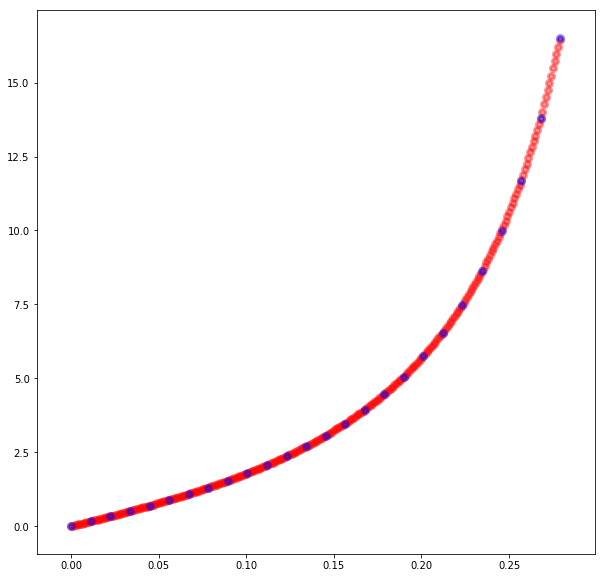

In [13]:
interpResMs = 1. / 1000
distTrav_fr
time_fr = np.array(tr['frameTime'][windowFr]- tr['frameTime'][windowFr[0]],np.float)
newTime_fr = np.arange(0,time_fr[-1],interpResMs)
newDist_fr = np.interp(newTime_fr, time_fr, distTrav_fr)

p, ax = plt.subplots(1, 1,figsize=(10,10)) #sharey=True)
cList = ['r','g','b']
lineHandles = []

newDistH = ax.scatter(newTime_fr,newDist_fr,color='r',linewidth=3,alpha = 0.4)
distH    = ax.scatter(time_fr,distTrav_fr,color='b',linewidth=3,alpha = 0.4)



# Plot constant vel model & observed

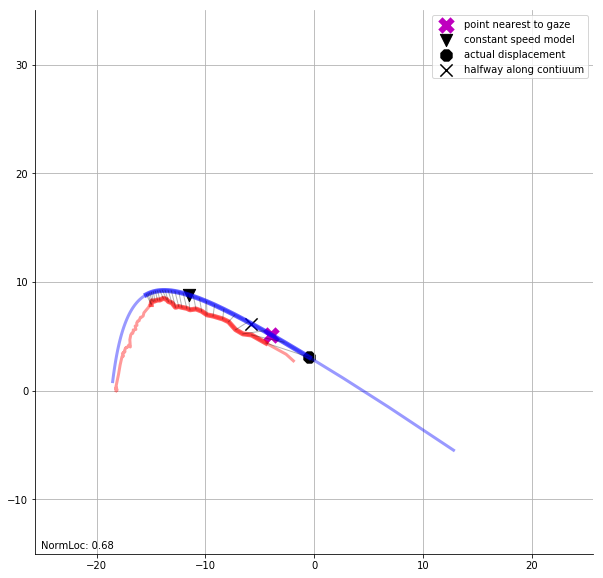

In [14]:
halfHFOVDegs = 80
analyzeUntilXSToArrival =  .2
stopAtXSToArrival = 0.075

endFr = int(trInfo['passVertPlaneAtPaddleFr'])
plotFr = tr.index[:endFr]

halfVFOVDegs = halfHFOVDegs / 1.77

p, ax = plt.subplots(1, 1,figsize=(10,10)) #sharey=True)
cList = ['r','g','b']
lineHandles = []

ballH = ax.plot(tr['ball_az'][plotFr],tr['ball_el'][plotFr],color='b',linewidth=3,alpha = 0.4)
gazeH = ax.plot(tr['cycGIW_az'][plotFr],tr['cycGIW_el'][plotFr],color='r',linewidth=3,alpha = 0.4)

startFr = int(trInfo['analysisStartFr'])
endFr = int(trInfo['analysisEndFr'])

windowFr = tr.index[startFr:endFr]
wStartFr = windowFr[0]
wEndFr = windowFr[-1]

ax.plot(tr['ball_az'][windowFr],tr['ball_el'][windowFr],color='b',linewidth=5, alpha = 0.6)
ax.plot(tr['cycGIW_az'][windowFr],tr['cycGIW_el'][windowFr],color='r',linewidth=5,alpha = 0.6)

for pf in windowFr:
    xs = [tr['ball_az'][pf], tr['cycGIW_az'][pf]]
    ys = [tr['ball_el'][pf], tr['cycGIW_el'][pf]]
    ax.plot(xs,ys,color='k',linewidth=1,alpha = 0.3)

ax.axis('equal')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
p.set_facecolor('w')

plt.xlim([-30,30])
plt.ylim([-15,35])


observedH = ax.scatter(ballWinEnd_AzEl[0],ballWinEnd_AzEl[1],c='k',s=150,marker='8')
constantVelH = ax.scatter(ballAtWinEndVelPred_AzEl[0],ballAtWinEndVelPred_AzEl[1],c='k',s=150,marker='v')
gazeLoc = ax.scatter(gazeMinDistLoc_AzEl[0],gazeMinDistLoc_AzEl[1],c='m',s=150,marker='x',lw=6)
halfWayH = ax.scatter(halfWayLocAzEl[0],halfWayLocAzEl[1],c='k',s=150,marker='x')

ax.text(.01,.01,str('NormLoc: {0:.2f}').format(normLocInWindow),transform=ax.transAxes)

ax.legend([gazeLoc,
           constantVelH,
           observedH,
            halfWayH], 
          
          ['point nearest to gaze',
           'constant speed model',
           'actual displacement',
           'halfway along contiuum'])

# ax.text(.01,.01,str('VelModel: {0:.2f}').format(float(trInfo['velPredError'])),transform=ax.transAxes)
# ax.text(.01,.04,str('Observed: {0:.2f}').format(float(trInfo['observedError'])),transform=ax.transAxes)

# az = trInfo['ballWinEnd_AzEl'].values[0][0]
# el = trInfo['ballWinEnd_AzEl'].values[0][1]
# ax.text(.01,.07,str('BallWinEnd: {0:.2f} {1:.2f}').format(az,el),transform=ax.transAxes)

# az = trInfo['gazeWinEnd_AzEl'].values[0][0]
# el = trInfo['gazeWinEnd_AzEl'].values[0][1]
# ax.text(.01,.1,str('GazeWinEnd: {0:.2f} {1:.2f}').format(az,el),transform=ax.transAxes)